**Get and visualize data**

In [ ]:
!git clone https://github.com/bckenstler/CLR.git
!git clone https://github.com/UCSD-AI4H/COVID-CT.git
%cd COVID-CT

Cloning into 'CLR'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 35.18 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Checking out files: 100% (1048/1048), done.
/content/COVID-CT


In [ ]:
%tensorflow_version 1.x
!pip install keras==2.2.4

from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, fbeta_score, recall_score, precision_score, confusion_matrix
import numpy as np
from zipfile import ZipFile
import os, cv2, shutil
shutil.copyfile('/content/CLR/clr_callback.py', '/content/COVID-CT/clr_callback.py')
from clr_callback import CyclicLR
import matplotlib.pyplot as plt
%matplotlib inline
 
from keras.models import load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback
import keras.backend as K
from math import pi, cos, floor

TensorFlow 1.x selected.
     |████████████████████████████████| 317kB 4.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


In [ ]:
def get_data(text_pos, text_neg, covid_fold, noncovid_fold, image_size = (192, 288, 3)):
  with open(text_pos, 'r') as fr:
    posimg_names = fr.read().split('\n')
    posimg_names = [aa for aa in posimg_names if aa != '']
    posimg_paths = [os.path.join(covid_fold, aa) for aa in posimg_names]
 
  with open(text_neg, 'r') as fr:
    negimg_names = fr.read().split('\n')
    negimg_names = [aa for aa in negimg_names if aa != '']
    negimg_paths = [os.path.join(noncovid_fold, aa) for aa in negimg_names]
 
  print(len(posimg_names), len(negimg_names))
  neg_len = len(negimg_names)//5 + 1
  mneg_len = len(negimg_names)
 
  ova_len = len(posimg_names) + mneg_len
  x_ = np.zeros((ova_len, image_size[0], image_size[1], image_size[2]), dtype = np.uint8)
  y_ = np.zeros((ova_len), dtype = np.float32)
  random_id = np.random.permutation(ova_len)
 
  for i in range(ova_len):
    if i<len(posimg_names):
      img = cv2.imread(posimg_paths[i])
      img = cv2.resize(img, (image_size[1],image_size[0]))
      y_[random_id[i]] = 1.0
    else:
      img = cv2.imread(negimg_paths[i-len(posimg_names)])
      img = cv2.resize(img, (image_size[1],image_size[0]))
      y_[random_id[i]] = 0.0
    x_[random_id[i]] = img
  return x_, y_
 
def segment_and_crop(segment_model, x_test, x_test_real, thresh_val = 0.5, add_pixel = 20):
  h, w = x_test.shape[1:3]
  y_preds = segment_model.predict(x_test)
  y_preds = (y_preds > thresh_val)*1.0
  for i, y_pred in enumerate(y_preds):
    y_axis, x_axis, _ = np.where(y_pred == 1.0)
    y_min = np.min(y_axis)
    y_min = y_min - add_pixel if y_min >= add_pixel else 0
    y_max = np.max(y_axis)
    y_max = y_max + add_pixel if y_max < h - add_pixel else h-1
    x_min = np.min(x_axis)
    x_min = x_min - add_pixel if x_min >= add_pixel else 0
    x_max = np.max(x_axis)
    x_max = x_max + add_pixel if x_max < w - add_pixel else w-1
    img_new = x_test_real[i][y_min:y_max, x_min:x_max]
    img_new = cv2.resize(img_new, (w, h))
    x_test_real[i] = img_new
  return x_test_real
 
def cal_confusion_matrics(y_pred, y_true, thresh_val = 0.5):
  y_binary = np.where(y_pred >= thresh_val, 1.0, 0.0)
  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0
  for i, items in enumerate(y_binary):
    if items == y_true[i]:
      if items == 1.0:
        true_positive += 1
      else:
        true_negative += 1
    else:
      if items == 1.0:
        false_positive += 1
      else:
        false_negative += 1
 
  sensitivity = true_positive / (true_positive + false_negative)
  specificity = true_negative / (true_negative + false_positive)
  accuracy = (true_positive + true_negative) / y_pred.shape[0]
  return sensitivity, specificity, accuracy, (true_positive, false_negative, true_negative, false_positive)
 
def bestThresshold(y_true,y_pred):
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.901, 0.01):
        score = fbeta_score(y_true, np.array(y_pred)>thresh, beta = 1)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    return best_score , best_thresh
 
class DataSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
 
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
 
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

from skimage.morphology import remove_small_objects, remove_small_holes
def segment_and_crop_wpp(segment_model, x_test, x_test_real, thresh_val = 0.5, add_pixel = 20, thresh_obj = 100, thresh_hole = 36):
  h, w = x_test.shape[1:3]
  y_preds = segment_model.predict(x_test)
  y_preds = y_preds > thresh_val
  for i, y_pred in enumerate(y_preds):
    remove_small_objects(y_pred, thresh_obj, in_place=True)
    remove_small_holes(y_pred, thresh_hole, in_place=True)
    y_pred = y_pred*1.0
    y_axis, x_axis, _ = np.where(y_pred == 1.0)
    y_min = np.min(y_axis)
    y_min = y_min - add_pixel if y_min >= add_pixel else 0
    y_max = np.max(y_axis)
    y_max = y_max + add_pixel if y_max < h - add_pixel else h-1
    x_min = np.min(x_axis)
    x_min = x_min - add_pixel if x_min >= add_pixel else 0
    x_max = np.max(x_axis)
    x_max = x_max + add_pixel if x_max < w - add_pixel else w-1
    img_new = x_test_real[i][y_min:y_max, x_min:x_max]
    img_new = cv2.resize(img_new, (w, h))
    x_test_real[i] = img_new
  return x_test_real
 
def full_process(classify_model, segment_model, image_test, thresh_classify = 0.5, thresh_segment = 0.5, border_pixel = 20, thresh_obj = 100, thresh_hole = 36):
  h,w = image_test.shape[:2]
  if image_test.shape[-1] == 1:
    x_test_real = np.concatenate((image_test, image_test, image_test), axis=-1)
    x_test_real = np.expand_dims(x_test_real, axis=0)
  elif image_test.shape[-1] == 3:
    x_test_real = np.expand_dims(image_test, axis=0)
  else:
    raise Error("input 'image_test' must be an array with 3 dimension and the last dimension is the channel of the image!!!")
  x_test = x_test_real[...,:1]
  y_preds = segment_model.predict(x_test)
  y_preds = y_preds > thresh_segment
  for i, y_pred in enumerate(y_preds):
    remove_small_objects(y_pred, thresh_obj, in_place=True)
    remove_small_holes(y_pred, thresh_hole, in_place=True)
    y_pred = y_pred*1.0
    y_axis, x_axis, _ = np.where(y_pred == 1.0)
    y_min = np.min(y_axis)
    y_min = y_min - border_pixel if y_min >= border_pixel else 0
    y_max = np.max(y_axis)
    y_max = y_max + border_pixel if y_max < h - border_pixel else h-1
    x_min = np.min(x_axis)
    x_min = x_min - border_pixel if x_min >= border_pixel else 0
    x_max = np.max(x_axis)
    x_max = x_max + border_pixel if x_max < w - border_pixel else w-1
    img_new = x_test_real[i][y_min:y_max, x_min:x_max]
    img_new = cv2.resize(img_new, (w, h))
    x_test_real[i] = img_new
  
  y_preds = classify_model.predict(x_test_real)
  return y_preds > thresh_classify

In [ ]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs={}):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		K.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)
 
	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))
 
# create snapshot ensemble callback
n_epochs = 150
n_cycles = n_epochs / 30
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.3)

In [ ]:
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        if self.clr_iterations % (2*self.step_size) == 0:
          # save model to file
          filename = "snapshot_model_%d.h5" % int(self.clr_iterations / (2*self.step_size))
          self.model.save(filename)
          print('>saved snapshot %s, epoch %d' % (filename, int(self.clr_iterations / (2*self.step_size))))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
extract_des = 'Images-processed/'
 
with ZipFile('Images-processed/CT_COVID.zip', 'r') as tt:
  tt.extractall(extract_des)
with ZipFile('Images-processed/CT_NonCOVID.zip', 'r') as tt:
  tt.extractall(extract_des)

In [ ]:
%cd COVID-CT
np.random.seed(1234)
image_size = (192, 288, 3)
 
covid_fold = extract_des + 'CT_COVID'
noncovid_fold = extract_des + 'CT_NonCOVID'
 
train_text_pos = 'Data-split/COVID/trainCT_COVID.txt'
test_text_pos = 'Data-split/COVID/testCT_COVID.txt'
val_text_pos = 'Data-split/COVID/valCT_COVID.txt'
 
train_text_neg = 'Data-split/NonCOVID/trainCT_NonCOVID.txt'
test_text_neg = 'Data-split/NonCOVID/testCT_NonCOVID.txt'
val_text_neg = 'Data-split/NonCOVID/valCT_NonCOVID.txt'
 
x_train, y_train = get_data(train_text_pos, train_text_neg, covid_fold, noncovid_fold, image_size = image_size)
x_test, y_test = get_data(test_text_pos, test_text_neg, covid_fold, noncovid_fold, image_size = image_size)
x_val, y_val = get_data(val_text_pos, val_text_neg, covid_fold, noncovid_fold, image_size = image_size)

[Errno 2] No such file or directory: 'COVID-CT'
/content/COVID-CT
191 234
98 105
60 58


In [ ]:
from albumentations import Compose, HorizontalFlip, CLAHE, HueSaturationValue,RandomBrightness, RandomContrast, RandomGamma,ToFloat, ShiftScaleRotate, VerticalFlip, RandomSizedCrop

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    #VerticalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    #RandomGamma(gamma_limit=(60, 120), p=0.6),
    RandomBrightness(limit=0.05, p=0.5),
    #HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0125, scale_limit=0.1, 
        rotate_limit=5, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    #ToFloat(max_value=255)
])

#cv2.BORDER_REFLECT_101
#cv2.BORDER_CONSTANT

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

In [ ]:
from google.colab import drive as drv
drv.mount('/content/drive')
 
model_segment = load_model('/content/drive/My Drive/model_segment_covid19_lung.hdf5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
thresh_segment = 0.5
add_pixel = 20
thresh_obj = 100
thresh_hole = 36
 
x_train = segment_and_crop_wpp(model_segment, x_train[...,:1], np.copy(x_train), thresh_val = thresh_segment, add_pixel = add_pixel, thresh_obj=thresh_obj, thresh_hole=thresh_hole)
x_test = segment_and_crop_wpp(model_segment, x_test[...,:1], np.copy(x_test), thresh_val = thresh_segment, add_pixel = add_pixel, thresh_obj=thresh_obj, thresh_hole=thresh_hole)
x_val = segment_and_crop_wpp(model_segment, x_val[...,:1], np.copy(x_val), thresh_val = thresh_segment, add_pixel = add_pixel, thresh_obj=thresh_obj, thresh_hole=thresh_hole)

In [ ]:
import tensorflow as tf
def classbalanced_binary_focal_loss(gamma=0.5, alpha_1=.01172, alpha_0=.01105):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha_1 * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean(alpha_0 * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

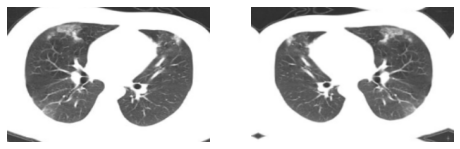

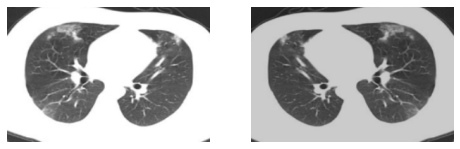

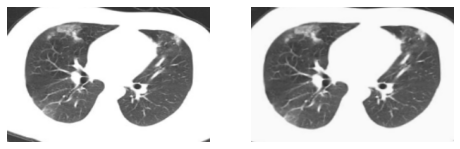

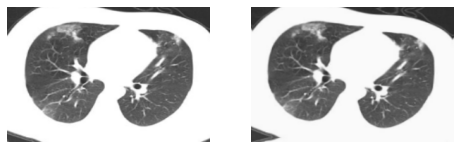

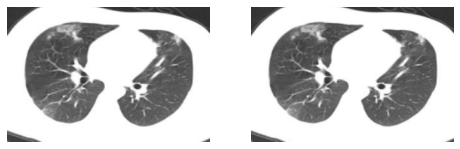

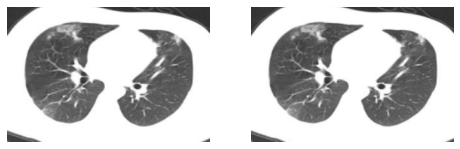

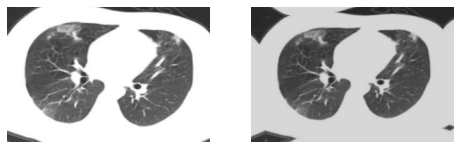

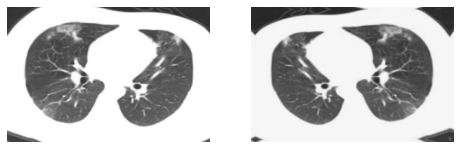

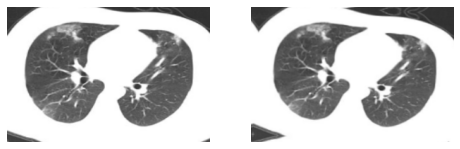

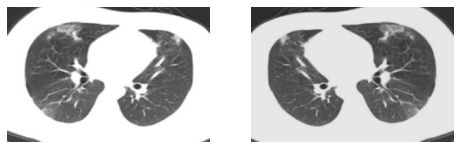

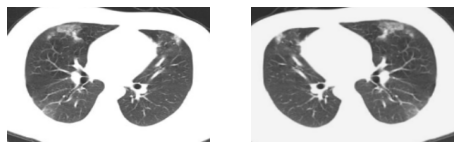

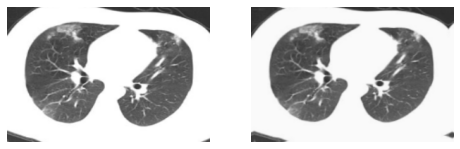

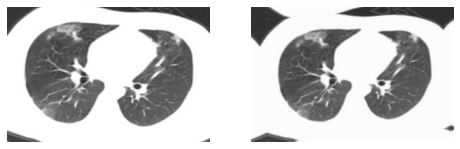

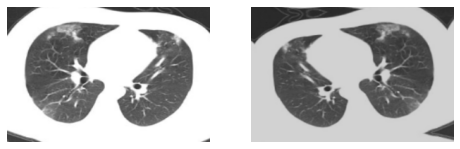

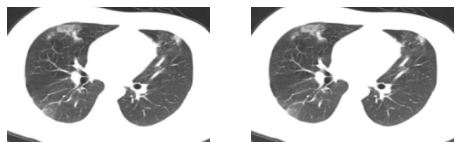

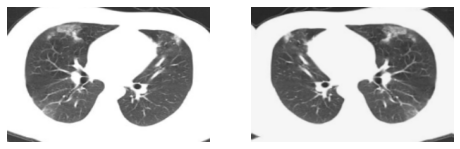

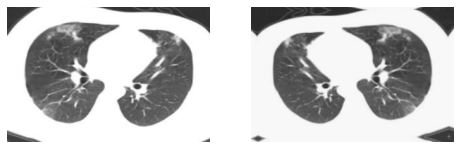

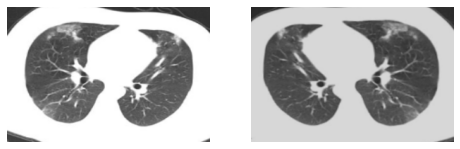

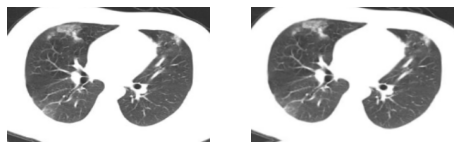

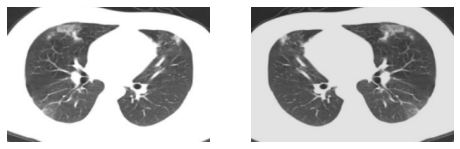

In [ ]:
for i in range(20):
  img=AUGMENTATIONS_TRAIN(image = x_test[0])['image']
  plt.figure(i)
  fig, axs = plt.subplots(1, 2, figsize = (8,8))
  axs[0].imshow(x_test[0]), axs[0].axis('off')
  axs[1].imshow(img), axs[1].axis('off')

In [ ]:
!pip install -U efficientnet
import efficientnet.keras as efn

In [ ]:
batch_size = 16
cycle_epochs = 30
step_size = (cycle_epochs//2)*(x_train.shape[0]//batch_size)
print(step_size)
clr = CyclicLR(base_lr=0.01, max_lr=0.1, step_size=step_size)

generator_x = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.1,
    shear_range = 5.0,
    rotation_range = 10
)
train_gen = generator_x.flow(x_train, y_train, batch_size = batch_size, shuffle = False, seed = 1234)
 
# train_gen = DataSequence(x_train, y_train, batch_size, augmentations=AUGMENTATIONS_TRAIN)

img_sen = Input(shape = image_size)
 
pretrained_model = efn.EfficientNetB4(include_top = False, weights = 'imagenet', input_tensor = img_sen)
global_avg = GlobalAveragePooling2D()(pretrained_model.output)
out_fc1 = Dense(1, activation = 'sigmoid')(global_avg)
#drop_layer = Dropout(rate = 0.2)(global_avg)
#out_fc1 = Dense(1, activation = 'sigmoid')(drop_layer)
 
model = Model(input = [img_sen], output = [out_fc1])

390


71892992/71892840 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [ ]:
pn = 191
nn = 234
beta = 0.9999
esp = (1 - beta**pn)/(1-beta)
esn = (1 - beta**nn)/(1-beta)
alpha_p = 1/esp
alpha_n = 1/esn
print(alpha_p, alpha_n)

optimize = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
optimize2 = Adam(lr = 3e-4)
# model.compile(optimizer = optimize, loss = classbalanced_binary_focal_loss(alpha_1 = alpha_p, alpha_0 = alpha_n), metrics = ['accuracy'])
model.compile(optimizer = optimize2, loss = 'binary_crossentropy', metrics = ['accuracy'])

0.005285499483430528 0.004323485602699997


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.load_weights('/content/drive/My Drive/EfficientB4_COVID-19_2stages_bestgen.h5')
model.evaluate(x_test, y_test)

203/203 [==============================] - 3s 13ms/step


[0.8259099334331569, 0.8177339916158779]

In [ ]:
class lr_scheduler(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 359:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      #current_lr = 1e-4
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))

In [ ]:
file_name = '/content/weights_save'
if os.path.exists(file_name):
  shutil.rmtree(file_name)
  
os.mkdir(file_name)

In [ ]:
!pip install keras-swa

     |████████████████████████████████| 81kB 2.3MB/s 
  Created wheel for keras-swa: filename=keras_swa-0.1.5-cp36-none-any.whl size=9712 sha256=bf807150394b479fb59510234490d960692a349146e3c4549d2a8d22bdea67d2
  Stored in directory: /root/.cache/pip/wheels/30/de/a7/f2a71861bb678729a45e8995dc2496118e875e64b89379c530
Successfully built keras-swa


In [ ]:
from swa.keras import SWA
start_epoch = 10
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr=0.001,
          swa_lr2=0.01,
          swa_freq=10,
          batch_size = batch_size,
          verbose=1)

In [ ]:
%cd /content/
checkpoint = ModelCheckpoint('/content/weights_save/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_weights_only=True, mode='auto')
# lr_decay = lr_scheduler()
callback_list = [checkpoint]#, lr_decay]
# callback_list = [clr]
 
#nếu thực hiên train với ảnh gốc thì chạy lệnh sau:
#history = model.fit_generator(generator_x.flow(x_train, y_train, batch_size = 4), epochs = 200, callbacks = callback_list, validation_data = (x_test, y_test))
#history = model.fit_generator(train_gen, epochs = 160, callbacks = callback_list, validation_data = (x_val, y_val))
history = model.fit_generator(train_gen, steps_per_epoch=x_train.shape[0]//batch_size,epochs = 100, callbacks = callback_list, validation_data = (x_test, y_test))
 
#nếu thực hiện train với ảnh crop_segment thì chạy lệnh sau:
#history = model.fit_generator(generator_x.flow(x_train_new, y_train, batch_size = 16), epochs = 200, callbacks = callback_list, validation_data = (x_test_new, y_test))

/content


Epoch 1/100
26/26 [==============================] - 69s 3s/step - loss: 0.5538 - acc: 0.6947 - val_loss: 0.5359 - val_acc: 0.7833

Epoch 00001: saving model to /content/weights_save/weights.01-0.54.hdf5
Epoch 2/100
26/26 [==============================] - 30s 1s/step - loss: 0.2519 - acc: 0.8918 - val_loss: 0.5624 - val_acc: 0.7931

Epoch 00002: saving model to /content/weights_save/weights.02-0.56.hdf5
Epoch 3/100
26/26 [==============================] - 28s 1s/step - loss: 0.1190 - acc: 0.9597 - val_loss: 0.5266 - val_acc: 0.8030

Epoch 00003: saving model to /content/weights_save/weights.03-0.53.hdf5
Epoch 4/100
26/26 [==============================] - 28s 1s/step - loss: 0.0898 - acc: 0.9717 - val_loss: 1.0392 - val_acc: 0.7340

Epoch 00004: saving model to /content/weights_save/weights.04-1.04.hdf5
Epoch 5/100
26/26 [==============================] - 28s 1s/step - loss: 0.0743 - acc: 0.9711 - val_loss: 1.0429 - val_acc: 0.7734

Epoch 00005: saving model to /content/wei

In [ ]:
h.keys()

dict_keys(['lr', 'iterations', 'batch', 'size', 'loss', 'acc'])

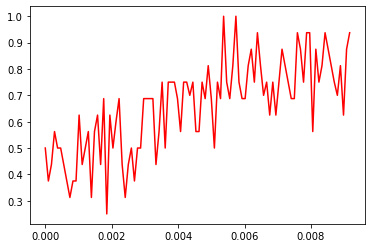

In [ ]:
h = clr.history
lr = h['lr']
acc = h['acc']

plt.plot(lr[:100], acc[:100],'r-',label='ROC curve with segment step')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'snapshot_model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# fit stacked model using the ensemble
meta_model = fit_stacked_model(members, x_val, y_val)
# evaluate model on test set
yhat = stacked_prediction(members, meta_model, x_test)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5
>loaded snapshot_model_4.h5
>loaded snapshot_model_5.h5
Loaded 5 models
Stacked Test Accuracy: 0.812


In [ ]:
# evaluate standalone models on test dataset
for model_ in members:
  #testy_enc = to_categorical(testy)
  _, acc = model_.evaluate(x_test, y_test, verbose=0)
  print('Model Accuracy: %.3f' % acc)
  _, acc = model_.evaluate(x_val, y_val, verbose=0)
  print('Model Accuracy validation: %.3f' % acc)

Model Accuracy: 0.796
Model Accuracy validation: 0.774
Model Accuracy: 0.829
Model Accuracy validation: 0.755
Model Accuracy: 0.818
Model Accuracy validation: 0.689
Model Accuracy: 0.829
Model Accuracy validation: 0.755
Model Accuracy: 0.845
Model Accuracy validation: 0.717


In [ ]:
model.evaluate(x_test, y_test)

181/181 [==============================] - 5s 28ms/step


[1.0603137230346216, 0.6850828742454065]

In [ ]:
a = history.history
list_valacc = a['val_acc']
argmax = [i for i, a in enumerate(list_valacc) if a == max(list_valacc)]
list_ws = next(os.walk('/content/weights_save'))[2]
argmax = argmax[-1]
if argmax < 9:
  best_dir = [a for a in list_ws if a.find('.0'+str(argmax+1)+'-') != -1]
else:
  best_dir = [a for a in list_ws if a.find('.'+str(argmax+1)+'-') != -1]
model.load_weights(os.path.join('/content/weights_save', best_dir[0]))
print(argmax, best_dir)
print(model.evaluate(x_val, y_val))
print(model.evaluate(x_test, y_test))

In [ ]:
model.load_weights('/content/drive/My Drive/EfficientB4_COVID-19_2stages_bestgen.h5')
# print(model.evaluate(x_test_crop, y_test))
# print(model.evaluate(x_val, y_val))

In [ ]:
model_classify = load_model('/content/drive/My Drive/EfficientB4_COVID-19_2stages_bestgen.hdf5')

In [ ]:
import time
for i in range(10):
  st = time.time()
  print(full_process(model, model_segment, x_test[i]))
  end = time.time()
  print('time takes %.2fms' % (1000*(end-st)))

[[ True]]
time takes 78.94ms
[[ True]]
time takes 77.46ms
[[ True]]
time takes 73.62ms
[[False]]
time takes 73.79ms
[[False]]
time takes 71.86ms
[[ True]]
time takes 69.88ms
[[False]]
time takes 71.33ms
[[False]]
time takes 70.67ms
[[False]]
time takes 70.04ms
[[ True]]
time takes 72.58ms


In [ ]:
model.save('scratch.hdf5')
model2 = load_model('scratch.hdf5')
model2.load_weights('/content/drive/My Drive/EfficientB4_COVID-19_nosegment.h5')
print(model2.evaluate(x_test, y_test))

In [ ]:
save_weights = True
if save_weights:
  model.save_weights('EfficientB4_COVID-19_2stages_bestgen2.h5')
  shutil.copyfile('EfficientB4_COVID-19_2stages_bestgen2.h5', '/content/drive/My Drive/EfficientB4_COVID-19_2stages_bestgen2.h5')

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
best_f1, best_thresh = bestThresshold(y_test, y_pred)
print(best_thresh, best_f1)

0.5199999999999998 0.8736842105263158


In [ ]:
thresh_val = 0.5
sensitivity, specificity, accuracy, (true_positive, false_negative, true_negative, false_positive) = cal_confusion_matrics(y_pred, y_test, thresh_val = thresh_val)
auc = roc_auc_score(y_test, y_pred)
aps = average_precision_score(y_test, y_pred)
f1 = fbeta_score(y_test, 1.0*(y_pred>thresh_val), beta = 1)
print(recall_score(y_test, 1.0*(y_pred>thresh_val)), precision_score(y_test, 1.0*(y_pred>thresh_val)))
print(sensitivity, specificity, accuracy, (true_positive, false_negative, true_negative, false_positive))
print(auc, aps, f1)

0.8469387755102041 0.8829787234042553
0.8469387755102041 0.8674698795180723 0.856353591160221 (83, 15, 72, 11)
0.8994344725842145 0.912465468110826 0.8645833333333334


In [ ]:
y_pred = model.predict(x_val)
best_f1, best_thresh = bestThresshold(y_val, y_pred)
print(best_thresh, best_f1)
thresh_val = 0.2
sensitivity, specificity, accuracy, (true_positive, false_negative, true_negative, false_positive) = cal_confusion_matrics(y_pred, y_val, thresh_val = thresh_val)
auc = roc_auc_score(y_val, y_pred)
aps = average_precision_score(y_val, y_pred)
f1 = fbeta_score(y_val, 1.0*(y_pred>thresh_val), beta = 1)
print(recall_score(y_val, 1.0*(y_pred>thresh_val)), precision_score(y_val, 1.0*(y_pred>thresh_val)))
print(sensitivity, specificity, accuracy, (true_positive, false_negative, true_negative, false_positive))
print(auc, aps, f1)

0.17999999999999997 0.8396946564885496
0.9166666666666666 0.7746478873239436
0.9166666666666666 0.6521739130434783 0.8018867924528302 (55, 5, 30, 16)
0.8938405797101449 0.9146073852132898 0.8396946564885496


In [ ]:
# y_pred2 = model2.predict(x_test)
y_pred = model.predict(x_test_crop)

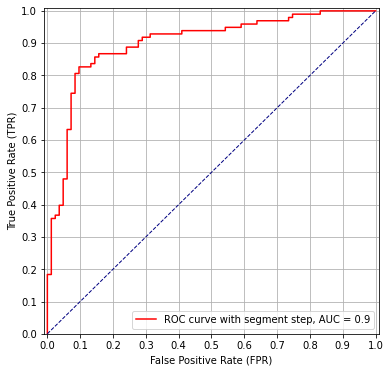

In [ ]:
tpr = []
fpr = []
tpr2 = []
fpr2 = []
for i in range(50001):
  thresh_val = i*0.00002
  a, b, c, d = cal_confusion_matrics(y_pred, y_test, thresh_val=thresh_val)
  tpr.append(a)
  fpr.append(1-b)
  # a2, b2, c2, d2 = cal_confusion_matrics(y_pred2, y_test, thresh_val=thresh_val)
  # tpr2.append(a2)
  # fpr2.append(1-b2)

axisRange = [0.0, 0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.figure(figsize=(6,6))
lw = 1
plt.grid(True)
# plt.plot(fpr2, tpr2,'b-',label='ROC curve without segment step' + ', AUC = '+str(round(roc_auc_score(y_test, y_pred2),3)))
plt.plot(fpr, tpr,'r-',label='ROC curve with segment step' + ', AUC = '+str(round(roc_auc_score(y_test, y_pred),3)))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.xticks(axisRange)
plt.yticks(axisRange)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

In [ ]:
from tkinter import *
root = Tk()
my_label = Label(root, text = 'hello world!')
my_label.pack()
root.mainloop()

In [ ]:
model.compile(optimize2, loss='binary_crossentropy', metrics=['accuracy'])
model.evaluate(x_test, y_test)

181/181 [==============================] - 6s 34ms/step


[1.0603137230346216, 0.6850828742454065]

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=x_train.shape[0]//batch_size,epochs = 30, validation_data = (x_test, y_test))

Epoch 1/30
23/23 [==============================] - 63s 3s/step - loss: 0.0667 - acc: 0.9767 - val_loss: 1.5861 - val_acc: 0.6298
Epoch 2/30
23/23 [==============================] - 25s 1s/step - loss: 0.1856 - acc: 0.9394 - val_loss: 0.7396 - val_acc: 0.7735
Epoch 3/30
23/23 [==============================] - 25s 1s/step - loss: 0.0851 - acc: 0.9615 - val_loss: 0.7753 - val_acc: 0.7956
Epoch 4/30
23/23 [==============================] - 25s 1s/step - loss: 0.0737 - acc: 0.9810 - val_loss: 1.0699 - val_acc: 0.8011
Epoch 5/30
23/23 [==============================] - 25s 1s/step - loss: 0.0578 - acc: 0.9778 - val_loss: 1.0053 - val_acc: 0.7735
Epoch 6/30
23/23 [==============================] - 25s 1s/step - loss: 0.0655 - acc: 0.9778 - val_loss: 0.8385 - val_acc: 0.8232
Epoch 7/30
23/23 [==============================] - 25s 1s/step - loss: 0.0339 - acc: 0.9837 - val_loss: 0.7455 - val_acc: 0.8011
Epoch 8/30
23/23 [==============================] - 25s 1s/step - loss: 0.0330 - acc: 0.99